In [32]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
import  statsmodels.stats.multitest as multitest
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# my understanding of background mutation rate model and p q value assignment

1. reference: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4217527/,
2. basic ideas: take 10kb upstream and downstream of a region of interest(ROI), calculate the total number of mutations in the 20kb flanking regions. this is divided by 20000 and further divided by the number of patients in the cohort to give us the background nucleotide mutation frequency q. q represents the chance/percentage of a single nucleotide which is mutated in a single patient. 
3. calculate the sample mutation rate p in ROI based on the formula with hotspot length and q obtained in step 2.
4. calculate p value based on the formula with p, number of patients in the cohort, number of observed patients k with mutations in the ROI, combination numbers of k, k-1, ... 0.
5. multiple comparison correction
6. ran into negative pvalue problems?

# 1. all files/constants

In [28]:
num_patients = 118
bgwindow_size = 1e4
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/'
# inmaf = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.maf'
# valhotspotsf = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/123_patients/sliding_window_mutaional_distance_merged_overlap_promoter_txn_factor_merged.txt'
nc_maf = '/projects/da_workspace/software/mutation_rainstorm/118_patients_noncoding/118_patients_noncoding.maf'
hsf = '/projects/da_workspace/software/mutation_rainstorm/118_patients_noncoding/waveletSummary_withMaf.tsv'
# fname = 'waveletPatientDetail_withMaf.tsv'
# infile = f'{wkdir}{fname}'
# outfile = f'{infile}.parsed'
# outfile

# 2. mutation matrix

In [3]:
muts = pd.read_csv(nc_maf, sep='\t', low_memory=False)
muts[:2]

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER
0,OR4G11P,0,.,GRCh37,1,59734,59734,+,5'Flank,SNP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS
1,RP11-206L10.5,0,.,GRCh37,1,694016,694016,+,3'Flank,SNP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS


In [4]:
keep = ['Hugo_Symbol',  'Chromosome', 'Start_Position', 'End_Position',  
        'Variant_Classification', 'Variant_Type', 'Tumor_Sample_Barcode', 'IMPACT']


In [5]:
muts.shape
muts = muts[keep]
muts['Variant_Type'].unique()
muts['IMPACT'].unique()
muts['Variant_Classification'].unique()

(2669443, 109)

array(['SNP', 'INS', 'DEL'], dtype=object)

array(['MODIFIER', 'LOW', 'HIGH'], dtype=object)

array(["5'Flank", "3'Flank", 'IGR', "3'UTR", 'Intron', "5'UTR", 'RNA',
       'Splice_Site', 'Translation_Start_Site'], dtype=object)

In [6]:
muts.head(2)

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT
0,OR4G11P,1,59734,59734,5'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER
1,RP11-206L10.5,1,694016,694016,3'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER


# 3. rainstorm hotspots

In [128]:
hs = pd.read_csv(hsf, sep='\t', low_memory=False)
hs.head()
hs.shape


,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol
1_130.1,10,118649,127947,124617,-4.725319,34,6.774922,3'Flank,5.171064,-2.650349,0.929096,3.978922,TUBB8
1_230.1,10,309876,310856,310617,-2.743790,7,7.135576,IGR,3.540816,-1.893609,0.638003,7.135576,UnknownGene
1_275.1,10,417609,417685,417609,-3.661250,5,77.922078,Intron,4.517758,-2.333202,0.745806,64.935065,DIP2C
1_530.1,10,781351,784410,783607,-3.913474,16,6.209150,IGR,5.303916,-2.388440,0.998424,5.555556,UnknownGene
1_786.1,10,1258065,1258630,1258577,-4.723719,6,12.367491,Intron,4.099677,-2.617559,1.687188,10.600707,ADARB2


(3094, 13)

In [133]:
# hs.sort_values('numberPatients', ascending=False).head(10)
hs[hs.Hugo_Symbol=='TERT']

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol,hotspot_length
1_12161.1,5,1283266,1284668,1284638,-5.076626,18,16.393443,Intron,5.107894,-3.557077,1.434621,12.829651,TERT,1402
1_1259.1,5,1295228,1295250,1295228,-7.762693,13,565.217391,5'Flank,12.358292,-6.504207,2.815591,521.739130,TERT,22


In [129]:
hs['hotspot_length'] = hs.rightPosition - hs.leftPosition

In [47]:
hs['hotspot_length'].sum()
hs['hotspot_length'].min()
hs['hotspot_length'].max()

3781695

0

14786

Text(0.5,21.7063,'hotspot length')

Text(36.6573,0.5,'number of patients')

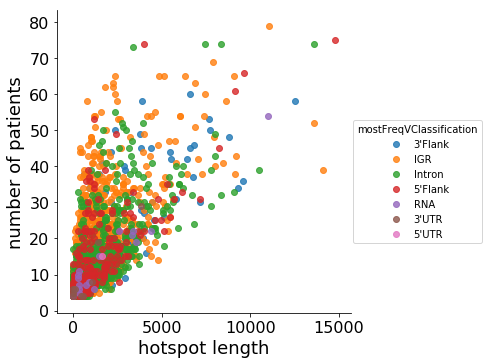

In [62]:
# sns.distplot(hs['hotspot_length'])
# fig, ax = plt.subplots(figsize=(8,8))
# ax.hist(hs['hotspot_length'], bins=50)
# ax.scatter(hs['hotspot_length'], hs['numberPatients'])
sns.lmplot('hotspot_length', 'numberPatients', data=hs, hue='mostFreqVClassification', fit_reg=False)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('hotspot length', fontsize=18)
plt.ylabel('number of patients', fontsize=18)

plt.savefig(f'{wkdir}hotspots_distribution.png',bbox_inches='tight' )


# 4. estimate nucleotide mutation rate, sample mutation rate, and p value

In [71]:
def count_bg_mutpats(muts, chrom, start, end, bgwindow_size):
    '''
    return fraction of patients with nc mutations per base in 10kb upstream
    and downstream the hotspot.  
    estimated nucleotide mutation rate for ROI q(i)?
    estimated sample mutation rate for ROI p(i)?
    '''
    start_10k = start - bgwindow_size
    end_10k = end + bgwindow_size
#     hotspot_length = end - start 
    muts_chr = muts[muts.Chromosome == str(chrom)]
    hs_subset = muts_chr[(((muts_chr.Start_Position >= start)&(muts_chr.Start_Position <= end))|
                          ((muts_chr.End_Position >= start)&(muts_chr.End_Position <= end)))]
    num_mutpats = hs_subset['Tumor_Sample_Barcode'].nunique()
    flank_subset = muts_chr[(((muts_chr.Start_Position < start)&(muts_chr.Start_Position > start_10k))
                       |((muts_chr.End_Position < start)&(muts_chr.End_Position > start_10k)))|
                      (((muts_chr.Start_Position < end_10k)&(muts_chr.Start_Position > end))
                       |((muts_chr.End_Position < end_10k)&(muts_chr.End_Position > end)))]
#     count all mutations, it does not need to be unique, 5 mutations at the same position is counted as 5
    num_mutations = flank_subset['Start_Position'].count()
    
    return num_mutations, num_mutpats

In [72]:
def bg_nucleotide_mrate(num_bg_mutations, num_patients, bgwindow_size):
    return num_bg_mutations/(2*bgwindow_size)/num_patients

In [73]:
def bg_sample_mrate(bg_nucleotide_mrate, hotspot_length):
    return 1 - ((1 - bg_nucleotide_mrate)**hotspot_length)

In [74]:
def hotspot_pvalue(bg_sample_mrate, observed_numpats, num_patients):
    '''
    calclute the chances of seeing the observed num of patients or more in ROI
    '''
    p = binom.pmf(range(observed_numpats, num_patients+1), num_patients, bg_sample_mrate).sum()
    return p

In [76]:
pvalues = []
for ix, row in hs.iterrows():
    chrom = row.chromosome
    start = row.leftPosition
    end = row.rightPosition
    rs_observed_numpats = row.numberPatients
    hs_length = end - start
    num_mutations, observed_mutpats = count_bg_mutpats(muts, chrom, start, end, bgwindow_size)
    nd_mrate = bg_nucleotide_mrate(num_mutations, num_patients, bgwindow_size)
    sp_mrate = bg_sample_mrate(nd_mrate, hs_length)
    hs_pvalue = hotspot_pvalue(sp_mrate, observed_mutpats, num_patients)
#     print(nd_mrate, sp_mrate, hs_length, hs_pvalue, num_mutations, rs_observed_numpats, observed_mutpats)
    pvalues.append(hs_pvalue)
   

In [77]:
hs = hs.reset_index()
hs['pvalues'] = pd.Series(pvalues)
hs.head()

,index,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol,pvalues
0,1_130.1,10,118649,127947,124617,-4.725319,34,6.774922,3'Flank,5.171064,-2.650349,0.929096,3.978922,TUBB8,6.062870e-01
1,1_230.1,10,309876,310856,310617,-2.743790,7,7.135576,IGR,3.540816,-1.893609,0.638003,7.135576,UnknownGene,7.401967e-07
2,1_275.1,10,417609,417685,417609,-3.661250,5,77.922078,Intron,4.517758,-2.333202,0.745806,64.935065,DIP2C,2.916519e-08
3,1_530.1,10,781351,784410,783607,-3.913474,16,6.209150,IGR,5.303916,-2.388440,0.998424,5.555556,UnknownGene,3.334898e-08
4,1_786.1,10,1258065,1258630,1258577,-4.723719,6,12.367491,Intron,4.099677,-2.617559,1.687188,10.600707,ADARB2,2.233725e-04


In [78]:
# plt.hist(muts_subset.Start_Position.sort_values(ascending=True))
# ((muts_subset.Start_Position > 118649)&(muts_subset.Start_Position<127947)).sum()

In [79]:
# hs[hs.ps<0.0000001]
hs[hs.Hugo_Symbol =='TERT']

,index,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol,pvalues
2073,1_12161.1,5,1283266,1284668,1284638,-5.076626,18,16.393443,Intron,5.107894,-3.557077,1.434621,12.829651,TERT,8.170820e-08
2074,1_1259.1,5,1295228,1295250,1295228,-7.762693,13,565.217391,5'Flank,12.358292,-6.504207,2.815591,521.739130,TERT,8.800128e-27


In [80]:
p_adjusted = multitest.multipletests(hs['pvalues'], method = 'fdr_bh')[1]
hs['fdr_bh'] = p_adjusted

In [81]:
hs.to_csv(f'{wkdir}rainstorm_hotspots_with_qvalue.txt', sep='\t', index=False)

In [82]:
hs[hs.fdr_bh<1e-30]

,index,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol,pvalues,fdr_bh
44,1_18886.1,10,38804327,38804327,38804327,-6.852316,7,7000.000000,IGR,4.719421,-6.777684,0.122215,7000.000000,UnknownGene,0.000000e+00,0.000000e+00
53,1_20246.1,10,39143058,39143058,39143058,-5.700762,6,6000.000000,IGR,4.645297,-5.632220,0.069941,5000.000000,UnknownGene,0.000000e+00,0.000000e+00
163,1_17681.1,11,39340995,39340995,39340995,-7.860150,7,7000.000000,IGR,13.460586,-7.811413,0.031287,5000.000000,UnknownGene,0.000000e+00,0.000000e+00
172,1_23059.1,11,48686582,48686582,48686582,-7.182225,6,6000.000000,IGR,7.771071,-7.147396,0.028213,5000.000000,UnknownGene,0.000000e+00,0.000000e+00
225,1_39781.1,11,83918124,83918124,83918124,-7.655094,4,4000.000000,Intron,10.108389,-7.615481,0.039375,4000.000000,DLG2,0.000000e+00,0.000000e+00
339,1_32183.1,12,67705323,67705326,67705323,-8.539392,9,2500.000000,Intron,17.212635,-6.069986,3.581217,2250.000000,CAND1,1.039021e-32,3.827060e-31
364,1_51543.1,12,108971391,108971391,108971391,-8.427569,5,5000.000000,IGR,11.338649,-8.316359,0.073239,5000.000000,UnknownGene,0.000000e+00,0.000000e+00
384,1_62566.1,12,130875762,130877933,130877220,-5.177679,44,26.243094,3'Flank,4.124009,-3.654239,1.048292,20.718232,RIMBP2,4.796748e-46,2.473523e-44
395,1_1281.1,13,19067704,19067704,19067704,-7.159624,5,5000.000000,3'Flank,4.734654,-7.097887,0.040108,5000.000000,BNIP3P7,0.000000e+00,0.000000e+00
436,1_19320.1,13,59623062,59623062,59623062,-3.419182,4,4000.000000,IGR,4.241534,-3.383364,0.032728,4000.000000,UnknownGene,0.000000e+00,0.000000e+00


### below is the code can be potentially adapted to find hotspots with >=3 patients within 9 bases 

In [8]:
muts.shape
muts[:2]

(2669443, 8)

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT
0,OR4G11P,1,59734,59734,5'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER
1,RP11-206L10.5,1,694016,694016,3'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER


In [9]:
muts[(muts.Chromosome=='9')&(muts.Start_Position >133660200)&(muts.Start_Position<133660761)]

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT
894658,ABL1,9,133660760,133660760,Intron,SNP,HTMCP-03-06-02128_T,MODIFIER
1047708,ABL1,9,133660206,133660206,Intron,SNP,HTMCP-03-06-02155_T,MODIFIER
1868764,ABL1,9,133660760,133660760,Intron,SNP,HTMCP-03-06-02266_T,MODIFIER
1880064,ABL1,9,133660760,133660760,Intron,SNP,HTMCP-03-06-02267_T,MODIFIER
2216486,ABL1,9,133660760,133660760,Intron,SNP,HTMCP-03-06-02354_T,MODIFIER
2661899,ABL1,9,133660760,133660760,Intron,SNP,HTMCP-03-06-02261_T,MODIFIER


In [10]:
hs.shape
hs[:2]

(3094, 13)

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol
1_130.1,10,118649,127947,124617,-4.725319,34,6.774922,3'Flank,5.171064,-2.650349,0.929096,3.978922,TUBB8
1_230.1,10,309876,310856,310617,-2.743790,7,7.135576,IGR,3.540816,-1.893609,0.638003,7.135576,UnknownGene


In [11]:
def position_patients(muts, start, region_len, poscol, patientcol):
    '''
    get patients with muations at each position for a cohort
    '''
#     vc_sr = pd.Series(np.zeros(region_len))
#     vc_sr.index = range(start, start+region_len, 1)
    vc_sr = muts[[poscol, patientcol]].groupby(poscol)[patientcol].unique().sort_index()
#     vc_df = pd.DataFrame(vc_sr)
#     vc_df[pa]
#     vc_sr[vc_sr_tmp.index.values] = vc_sr_tmp.values
    return vc_sr


In [23]:
def window_patients(df, start, region_len, wsize, stride, chrom, threshold):
#     print('-----------')
    if chrom == 'X':
        chrom = '23'
    if chrom == 'Y':
        chrom = '24'
    wnum = math.floor((region_len - wsize)/stride)
#     print(wnum)
    window_counts = []
    if region_len >= wsize:
        for i in range(wnum):
            wstart = start + stride * i
            wend = wstart + wsize
            s = df[(df.Start_Position>=wstart)&(df.Start_Position<=wend)]['Tumor_Sample_Barcode']
#             print(f'window {wstart}-{wend}: patient: {s}')
            slist = [st for row in s for st in row]
            window_counts.append([chrom, wstart, wend, len(set(slist))])
    else:
        wstart = start
        wend = wstart + length
        s = df['Tumor_Sample_Barcode']
        slist = [st for row in s for st in row]
        #         print(len(set(slist)))
        window_counts.append([chrom, wstart, wend, len(set(slist))])

    df = pd.DataFrame(window_counts)
    if not df.empty:
        df.columns = ['chrom', 'start', 'end', 'num_patients']
        df = df[df['num_patients'] >=3]
    return df


In [320]:
hstmp = hs[hs.Hugo_Symbol=='ABL1']

In [24]:
hotspots = pd.DataFrame()
wsize = 9
stride = 1
threshold = 3
for ix, row in hs.iterrows() :
    hsid = ix
    chrom = row.chromosome
    start = row.leftPosition
    end = row.rightPosition
    length = end - start + 1
    print(f'processing hotspot: {hsid} on crhomosome {chrom}, hotspot length is {length}, {chrom}:{start}-{end}')
    muts_subset = muts[(muts.Chromosome == chrom)&(muts.Start_Position >= start)&(muts.End_Position <= end)]
    hs_patients = position_patients(muts_subset, start, length, 'Start_Position', 'Tumor_Sample_Barcode')
    hs_patients = pd.DataFrame(hs_patients)
    hs_patients = hs_patients.reset_index()
    dftmp = window_patients(hs_patients, start, length, wsize, stride, chrom, threshold)
#     dftmp
    if hotspots.empty:
        hotspots = dftmp
    else:
        hotspots = pd.concat([hotspots, dftmp])
 


processing hotspot: 1_130.1 on crhomosome 10, hotspot length is 9299, 10:118649-127947
processing hotspot: 1_230.1 on crhomosome 10, hotspot length is 981, 10:309876-310856
processing hotspot: 1_275.1 on crhomosome 10, hotspot length is 77, 10:417609-417685
processing hotspot: 1_530.1 on crhomosome 10, hotspot length is 3060, 10:781351-784410
processing hotspot: 1_786.1 on crhomosome 10, hotspot length is 566, 10:1258065-1258630
processing hotspot: 1_901.1 on crhomosome 10, hotspot length is 1324, 10:1382323-1383646
processing hotspot: 1_955.1 on crhomosome 10, hotspot length is 696, 10:1480271-1480966
processing hotspot: 1_977.1 on crhomosome 10, hotspot length is 858, 10:1505691-1506548
processing hotspot: 1_1049.1 on crhomosome 10, hotspot length is 1113, 10:1618521-1619633
processing hotspot: 1_1076.1 on crhomosome 10, hotspot length is 1217, 10:1658625-1659841
processing hotspot: 1_1456.1 on crhomosome 10, hotspot length is 215, 10:2278204-2278418
processing hotspot: 1_2036.1 on c

processing hotspot: 1_32897.1 on crhomosome 10, hotspot length is 1177, 10:64129972-64131148
processing hotspot: 1_33973.1 on crhomosome 10, hotspot length is 729, 10:66312792-66313520
processing hotspot: 1_35453.1 on crhomosome 10, hotspot length is 397, 10:68189415-68189811
processing hotspot: 1_37830.1 on crhomosome 10, hotspot length is 2072, 10:73517706-73519777
processing hotspot: 1_39577.1 on crhomosome 10, hotspot length is 437, 10:78125122-78125558
processing hotspot: 1_41648.1 on crhomosome 10, hotspot length is 372, 10:83106155-83106526
processing hotspot: 1_42404.1 on crhomosome 10, hotspot length is 69, 10:84106623-84106691
processing hotspot: 1_42945.1 on crhomosome 10, hotspot length is 198, 10:84821945-84822142
processing hotspot: 1_43639.1 on crhomosome 10, hotspot length is 72, 10:86217013-86217084
processing hotspot: 1_43783.1 on crhomosome 10, hotspot length is 136, 10:86553732-86553867
processing hotspot: 1_46464.1 on crhomosome 10, hotspot length is 1029, 10:93332

processing hotspot: 1_23721.1 on crhomosome 11, hotspot length is 890, 11:48935004-48935893
processing hotspot: 1_23764.1 on crhomosome 11, hotspot length is 923, 11:48937986-48938908
processing hotspot: 1_23851.1 on crhomosome 11, hotspot length is 2090, 11:48955919-48958008
processing hotspot: 1_23887.1 on crhomosome 11, hotspot length is 881, 11:48962784-48963664
processing hotspot: 1_24501.1 on crhomosome 11, hotspot length is 1596, 11:49846001-49847596
processing hotspot: 1_24829.1 on crhomosome 11, hotspot length is 4607, 11:50254236-50258842
processing hotspot: 1_24983.1 on crhomosome 11, hotspot length is 386, 11:50408163-50408548
processing hotspot: 1_25015.1 on crhomosome 11, hotspot length is 767, 11:50411501-50412267
processing hotspot: 1_25270.1 on crhomosome 11, hotspot length is 1920, 11:50650341-50652260
processing hotspot: 1_25347.1 on crhomosome 11, hotspot length is 2200, 11:50689273-50691472
processing hotspot: 1_25432.1 on crhomosome 11, hotspot length is 2822, 11:

processing hotspot: 1_3511.1 on crhomosome 12, hotspot length is 2007, 12:8056940-8058946
processing hotspot: 1_3546.1 on crhomosome 12, hotspot length is 2386, 12:8107896-8110281
processing hotspot: 1_3650.1 on crhomosome 12, hotspot length is 279, 12:8335440-8335718
processing hotspot: 1_3792.1 on crhomosome 12, hotspot length is 8361, 12:8384773-8393133
processing hotspot: 1_3827.1 on crhomosome 12, hotspot length is 1205, 12:8417407-8418611
processing hotspot: 1_3966.1 on crhomosome 12, hotspot length is 7772, 12:8544014-8551785
processing hotspot: 1_5021.1 on crhomosome 12, hotspot length is 1972, 12:11171917-11173888
processing hotspot: 1_5061.1 on crhomosome 12, hotspot length is 3155, 12:11206883-11210037
processing hotspot: 1_5085.1 on crhomosome 12, hotspot length is 1681, 12:11231982-11233662
processing hotspot: 1_6386.1 on crhomosome 12, hotspot length is 206, 12:14537021-14537226
processing hotspot: 1_8894.1 on crhomosome 12, hotspot length is 74, 12:19493334-19493407
proc

processing hotspot: 1_45903.1 on crhomosome 12, hotspot length is 638, 12:96509778-96510415
processing hotspot: 1_47505.1 on crhomosome 12, hotspot length is 848, 12:99856712-99857559
processing hotspot: 1_48818.1 on crhomosome 12, hotspot length is 399, 12:102759773-102760171
processing hotspot: 1_49063.1 on crhomosome 12, hotspot length is 669, 12:103141202-103141870
processing hotspot: 1_49233.1 on crhomosome 12, hotspot length is 307, 12:103416574-103416880
processing hotspot: 1_51234.1 on crhomosome 12, hotspot length is 1217, 12:108350087-108351303
processing hotspot: 1_51543.1 on crhomosome 12, hotspot length is 1, 12:108971391-108971391
processing hotspot: 1_51813.1 on crhomosome 12, hotspot length is 236, 12:109647743-109647978
processing hotspot: 1_51970.1 on crhomosome 12, hotspot length is 1449, 12:110098322-110099770
processing hotspot: 1_52195.1 on crhomosome 12, hotspot length is 169, 12:110610664-110610832
processing hotspot: 1_52432.1 on crhomosome 12, hotspot length i

processing hotspot: 1_25882.1 on crhomosome 13, hotspot length is 798, 13:67147700-67148497
processing hotspot: 1_26111.1 on crhomosome 13, hotspot length is 1541, 13:67353979-67355519
processing hotspot: 1_26193.1 on crhomosome 13, hotspot length is 242, 13:67423406-67423647
processing hotspot: 1_26782.1 on crhomosome 13, hotspot length is 1107, 13:67997549-67998655
processing hotspot: 1_26980.1 on crhomosome 13, hotspot length is 693, 13:68181870-68182562
processing hotspot: 1_27280.1 on crhomosome 13, hotspot length is 1272, 13:68483130-68484401
processing hotspot: 1_28334.1 on crhomosome 13, hotspot length is 981, 13:69441744-69442724
processing hotspot: 1_28650.1 on crhomosome 13, hotspot length is 966, 13:69707639-69708604
processing hotspot: 1_29165.1 on crhomosome 13, hotspot length is 330, 13:70192234-70192563
processing hotspot: 1_29503.1 on crhomosome 13, hotspot length is 629, 13:70529611-70530239
processing hotspot: 1_30087.1 on crhomosome 13, hotspot length is 1362, 13:71

processing hotspot: 1_8489.1 on crhomosome 14, hotspot length is 1143, 14:30458723-30459865
processing hotspot: 1_8720.1 on crhomosome 14, hotspot length is 648, 14:30843117-30843764
processing hotspot: 1_9668.1 on crhomosome 14, hotspot length is 5, 14:33269263-33269267
processing hotspot: 1_10963.1 on crhomosome 14, hotspot length is 325, 14:36417311-36417635
processing hotspot: 1_12284.1 on crhomosome 14, hotspot length is 1, 14:39226404-39226404
processing hotspot: 1_13212.1 on crhomosome 14, hotspot length is 874, 14:40926719-40927592
processing hotspot: 1_13600.1 on crhomosome 14, hotspot length is 1712, 14:41414920-41416631
processing hotspot: 1_14101.1 on crhomosome 14, hotspot length is 5, 14:41994674-41994678
processing hotspot: 1_14242.1 on crhomosome 14, hotspot length is 2117, 14:42141573-42143689
processing hotspot: 1_14442.1 on crhomosome 14, hotspot length is 1098, 14:42376281-42377378
processing hotspot: 1_14602.1 on crhomosome 14, hotspot length is 302, 14:42562090-42

processing hotspot: 1_2403.1 on crhomosome 15, hotspot length is 346, 15:20845858-20846203
processing hotspot: 1_2419.1 on crhomosome 15, hotspot length is 447, 15:20861625-20862071
processing hotspot: 1_2513.1 on crhomosome 15, hotspot length is 3074, 15:21021996-21025069
processing hotspot: 1_2702.1 on crhomosome 15, hotspot length is 3123, 15:21314824-21317946
processing hotspot: 1_3077.1 on crhomosome 15, hotspot length is 61, 15:22337497-22337557
processing hotspot: 1_3234.1 on crhomosome 15, hotspot length is 892, 15:22466617-22467508
processing hotspot: 1_3451.1 on crhomosome 15, hotspot length is 496, 15:22661066-22661561
processing hotspot: 1_3548.1 on crhomosome 15, hotspot length is 9675, 15:22822737-22832411
processing hotspot: 1_4212.1 on crhomosome 15, hotspot length is 1430, 15:23920315-23921744
processing hotspot: 1_4825.1 on crhomosome 15, hotspot length is 198, 15:24640853-24641050
processing hotspot: 1_5290.1 on crhomosome 15, hotspot length is 378, 15:25163670-25164

processing hotspot: 1_15868.1 on crhomosome 16, hotspot length is 524, 16:31970279-31970802
processing hotspot: 1_16017.1 on crhomosome 16, hotspot length is 859, 16:32108398-32109256
processing hotspot: 1_16320.1 on crhomosome 16, hotspot length is 346, 16:32126567-32126912
processing hotspot: 1_16395.1 on crhomosome 16, hotspot length is 1244, 16:32133895-32135138
processing hotspot: 1_16541.1 on crhomosome 16, hotspot length is 419, 16:32138863-32139281
processing hotspot: 1_16567.1 on crhomosome 16, hotspot length is 914, 16:32140520-32141433
processing hotspot: 1_16652.1 on crhomosome 16, hotspot length is 1679, 16:32151737-32153415
processing hotspot: 1_16729.1 on crhomosome 16, hotspot length is 273, 16:32157537-32157809
processing hotspot: 1_17431.1 on crhomosome 16, hotspot length is 607, 16:32429476-32430082
processing hotspot: 1_17678.1 on crhomosome 16, hotspot length is 127, 16:32467489-32467615
processing hotspot: 1_17709.1 on crhomosome 16, hotspot length is 51, 16:32476

processing hotspot: 1_38653.1 on crhomosome 16, hotspot length is 1437, 16:74143385-74144821
processing hotspot: 1_40252.1 on crhomosome 16, hotspot length is 107, 16:77367872-77367978
processing hotspot: 1_41677.1 on crhomosome 16, hotspot length is 2184, 16:80229030-80231213
processing hotspot: 1_42051.1 on crhomosome 16, hotspot length is 258, 16:80983746-80984003
processing hotspot: 1_43099.1 on crhomosome 16, hotspot length is 1454, 16:83412094-83413547
processing hotspot: 1_44320.1 on crhomosome 16, hotspot length is 1408, 16:86266044-86267451
processing hotspot: 1_44470.1 on crhomosome 16, hotspot length is 388, 16:86497672-86498059
processing hotspot: 1_44661.1 on crhomosome 16, hotspot length is 2210, 16:86877600-86879809
processing hotspot: 1_44699.1 on crhomosome 16, hotspot length is 2341, 16:86920960-86923300
processing hotspot: 1_45928.1 on crhomosome 16, hotspot length is 507, 16:89135261-89135767
processing hotspot: 1_460071.1 on crhomosome 16, hotspot length is 1148, 1

processing hotspot: 1_4248.1 on crhomosome 18, hotspot length is 1108, 18:6937119-6938226
processing hotspot: 1_4410.1 on crhomosome 18, hotspot length is 2183, 18:7176534-7178716
processing hotspot: 1_5578.1 on crhomosome 18, hotspot length is 189, 18:9449174-9449362
processing hotspot: 1_6177.1 on crhomosome 18, hotspot length is 1383, 18:10914871-10916253
processing hotspot: 1_7415.1 on crhomosome 18, hotspot length is 1251, 18:13498152-13499402
processing hotspot: 1_7500.1 on crhomosome 18, hotspot length is 1714, 18:13673861-13675574
processing hotspot: 1_7830.1 on crhomosome 18, hotspot length is 2056, 18:14185368-14187423
processing hotspot: 1_7875.1 on crhomosome 18, hotspot length is 711, 18:14203949-14204659
processing hotspot: 1_7943.1 on crhomosome 18, hotspot length is 915, 18:14254434-14255348
processing hotspot: 1_8024.1 on crhomosome 18, hotspot length is 1122, 18:14268926-14270047
processing hotspot: 1_8118.1 on crhomosome 18, hotspot length is 484, 18:14324372-1432485

processing hotspot: 1_193.1 on crhomosome 19, hotspot length is 1801, 19:383791-385591
processing hotspot: 1_380.1 on crhomosome 19, hotspot length is 1195, 19:602128-603322
processing hotspot: 1_502.1 on crhomosome 19, hotspot length is 2183, 19:832069-834251
processing hotspot: 1_545.1 on crhomosome 19, hotspot length is 2885, 19:876879-879763
processing hotspot: 1_674.1 on crhomosome 19, hotspot length is 543, 19:1164407-1164949
processing hotspot: 1_1095.1 on crhomosome 19, hotspot length is 690, 19:2130715-2131404
processing hotspot: 1_1203.1 on crhomosome 19, hotspot length is 3303, 19:2346945-2350247
processing hotspot: 1_1679.1 on crhomosome 19, hotspot length is 1092, 19:3298610-3299701
processing hotspot: 1_1996.1 on crhomosome 19, hotspot length is 583, 19:4035751-4036333
processing hotspot: 1_3799.1 on crhomosome 19, hotspot length is 1615, 19:8598003-8599617
processing hotspot: 1_3937.1 on crhomosome 19, hotspot length is 1911, 19:8878636-8880546
processing hotspot: 1_5738

processing hotspot: 1_1461.1 on crhomosome 1, hotspot length is 5318, 1:2585854-2591171
processing hotspot: 1_1505.1 on crhomosome 1, hotspot length is 356, 1:2608816-2609171
processing hotspot: 1_1588.1 on crhomosome 1, hotspot length is 1073, 1:2617146-2618218
processing hotspot: 1_1814.1 on crhomosome 1, hotspot length is 3976, 1:2627812-2631787
processing hotspot: 1_1859.1 on crhomosome 1, hotspot length is 2047, 1:2688037-2690083
processing hotspot: 1_1924.1 on crhomosome 1, hotspot length is 611, 1:2765522-2766132
processing hotspot: 1_2136.1 on crhomosome 1, hotspot length is 718, 1:3097664-3098381
processing hotspot: 1_2619.1 on crhomosome 1, hotspot length is 1787, 1:4136892-4138678
processing hotspot: 1_2689.1 on crhomosome 1, hotspot length is 1620, 1:4203107-4204726
processing hotspot: 1_2787.1 on crhomosome 1, hotspot length is 220, 1:4391955-4392174
processing hotspot: 1_2970.1 on crhomosome 1, hotspot length is 1595, 1:4691703-4693297
processing hotspot: 1_3009.1 on crho

processing hotspot: 1_59444.1 on crhomosome 1, hotspot length is 762, 1:142551093-142551854
processing hotspot: 1_59444.37 on crhomosome 1, hotspot length is 995, 1:142551093-142552087
processing hotspot: 1_59581.1 on crhomosome 1, hotspot length is 589, 1:142555754-142556342
processing hotspot: 1_59690.1 on crhomosome 1, hotspot length is 346, 1:142565539-142565884
processing hotspot: 1_59768.1 on crhomosome 1, hotspot length is 244, 1:142572711-142572954
processing hotspot: 1_59857.1 on crhomosome 1, hotspot length is 360, 1:142582410-142582769
processing hotspot: 1_59981.1 on crhomosome 1, hotspot length is 57, 1:142591629-142591685
processing hotspot: 1_60049.1 on crhomosome 1, hotspot length is 248, 1:142598044-142598291
processing hotspot: 1_60094.1 on crhomosome 1, hotspot length is 503, 1:142600838-142601340
processing hotspot: 1_60158.1 on crhomosome 1, hotspot length is 78, 1:142607672-142607749
processing hotspot: 1_60259.1 on crhomosome 1, hotspot length is 280, 1:142619283

processing hotspot: 1_84289.1 on crhomosome 1, hotspot length is 1, 1:182255516-182255516
processing hotspot: 1_84657.1 on crhomosome 1, hotspot length is 431, 1:183118541-183118971
processing hotspot: 1_85655.1 on crhomosome 1, hotspot length is 1470, 1:185623586-185625055
processing hotspot: 1_85982.1 on crhomosome 1, hotspot length is 439, 1:186295993-186296431
processing hotspot: 1_86199.1 on crhomosome 1, hotspot length is 529, 1:186770766-186771294
processing hotspot: 1_86295.1 on crhomosome 1, hotspot length is 7, 1:187011101-187011107
processing hotspot: 1_87055.1 on crhomosome 1, hotspot length is 505, 1:188002113-188002617
processing hotspot: 1_88963.1 on crhomosome 1, hotspot length is 1274, 1:189799656-189800929
processing hotspot: 1_89196.1 on crhomosome 1, hotspot length is 2, 1:190002851-190002852
processing hotspot: 1_89649.1 on crhomosome 1, hotspot length is 1139, 1:190415614-190416752
processing hotspot: 1_90266.1 on crhomosome 1, hotspot length is 327, 1:190951812-1

processing hotspot: 1_9170.1 on crhomosome 20, hotspot length is 1018, 20:18892374-18893391
processing hotspot: 1_93151.1 on crhomosome 20, hotspot length is 419, 20:19154451-19154869
processing hotspot: 1_9827.1 on crhomosome 20, hotspot length is 1148, 20:20299907-20301054
processing hotspot: 1_9864.1 on crhomosome 20, hotspot length is 3326, 20:20335198-20338523
processing hotspot: 1_10545.1 on crhomosome 20, hotspot length is 1203, 20:21701962-21703164
processing hotspot: 1_10823.1 on crhomosome 20, hotspot length is 777, 20:22062961-22063737
processing hotspot: 1_11087.1 on crhomosome 20, hotspot length is 647, 20:22519010-22519656
processing hotspot: 1_12261.1 on crhomosome 20, hotspot length is 99, 20:24662702-24662800
processing hotspot: 1_12640.1 on crhomosome 20, hotspot length is 881, 20:25529165-25530045
processing hotspot: 1_12738.1 on crhomosome 20, hotspot length is 539, 20:25734697-25735235
processing hotspot: 1_12826.1 on crhomosome 20, hotspot length is 879, 20:257405

processing hotspot: 1_337.1 on crhomosome 21, hotspot length is 1, 21:9582127-9582127
processing hotspot: 1_993.1 on crhomosome 21, hotspot length is 2840, 21:9727910-9730749
processing hotspot: 1_1447.1 on crhomosome 21, hotspot length is 85, 21:9937323-9937407
processing hotspot: 1_2387.1 on crhomosome 21, hotspot length is 684, 21:10529662-10530345
processing hotspot: 1_2590.1 on crhomosome 21, hotspot length is 5416, 21:10615901-10621316
processing hotspot: 1_2923.1 on crhomosome 21, hotspot length is 192, 21:10833610-10833801
processing hotspot: 1_3161.1 on crhomosome 21, hotspot length is 279, 21:10893016-10893294
processing hotspot: 1_4243.1 on crhomosome 21, hotspot length is 1486, 21:14395924-14397409
processing hotspot: 1_4670.1 on crhomosome 21, hotspot length is 1487, 21:14527024-14528510
processing hotspot: 1_4839.1 on crhomosome 21, hotspot length is 1302, 21:14726982-14728283
processing hotspot: 1_51331.1 on crhomosome 21, hotspot length is 2240, 21:15220270-15222509
pro

processing hotspot: 1_30496.1 on crhomosome 2, hotspot length is 1213, 2:57417449-57418661
processing hotspot: 1_30597.1 on crhomosome 2, hotspot length is 1232, 2:57535012-57536243
processing hotspot: 1_31139.1 on crhomosome 2, hotspot length is 346, 2:58364050-58364395
processing hotspot: 1_32061.1 on crhomosome 2, hotspot length is 1203, 2:60079539-60080741
processing hotspot: 1_32333.1 on crhomosome 2, hotspot length is 316, 2:60694761-60695076
processing hotspot: 1_33094.1 on crhomosome 2, hotspot length is 5, 2:62517765-62517769
processing hotspot: 1_35698.1 on crhomosome 2, hotspot length is 368, 2:68845181-68845548
processing hotspot: 1_37597.1 on crhomosome 2, hotspot length is 810, 2:73577420-73578229
processing hotspot: 1_37790.1 on crhomosome 2, hotspot length is 506, 2:73998684-73999189
processing hotspot: 1_39257.1 on crhomosome 2, hotspot length is 140, 2:76900462-76900601
processing hotspot: 1_41562.1 on crhomosome 2, hotspot length is 981, 2:79195645-79196625
processin

processing hotspot: 1_69439.1 on crhomosome 2, hotspot length is 1354, 2:125266796-125268149
processing hotspot: 1_70843.1 on crhomosome 2, hotspot length is 1634, 2:126941549-126943182
processing hotspot: 1_73236.1 on crhomosome 2, hotspot length is 4031, 2:132041875-132045905
processing hotspot: 1_73476.1 on crhomosome 2, hotspot length is 2085, 2:132405797-132407881
processing hotspot: 1_73555.1 on crhomosome 2, hotspot length is 249, 2:132518816-132519064
processing hotspot: 1_73602.1 on crhomosome 2, hotspot length is 619, 2:132548711-132549329
processing hotspot: 1_73785.1 on crhomosome 2, hotspot length is 2669, 2:132768550-132771218
processing hotspot: 1_74008.1 on crhomosome 2, hotspot length is 154, 2:132778443-132778596
processing hotspot: 1_74037.1 on crhomosome 2, hotspot length is 1338, 2:132781584-132782921
processing hotspot: 1_74176.1 on crhomosome 2, hotspot length is 764, 2:132787026-132787789
processing hotspot: 1_74242.1 on crhomosome 2, hotspot length is 1829, 2:1

processing hotspot: 1_3507.1 on crhomosome 3, hotspot length is 2235, 3:6048456-6050690
processing hotspot: 1_4662.1 on crhomosome 3, hotspot length is 1434, 3:8086737-8088170
processing hotspot: 1_53831.1 on crhomosome 3, hotspot length is 2303, 3:9888823-9891125
processing hotspot: 1_5472.1 on crhomosome 3, hotspot length is 1146, 3:10105241-10106386
processing hotspot: 1_6414.1 on crhomosome 3, hotspot length is 98, 3:12715680-12715777
processing hotspot: 1_7448.1 on crhomosome 3, hotspot length is 673, 3:15950078-15950750
processing hotspot: 1_7678.1 on crhomosome 3, hotspot length is 1164, 3:16578600-16579763
processing hotspot: 1_9224.1 on crhomosome 3, hotspot length is 241, 3:20060176-20060416
processing hotspot: 1_9661.1 on crhomosome 3, hotspot length is 3106, 3:20893900-20897005
processing hotspot: 1_9854.1 on crhomosome 3, hotspot length is 1341, 3:21188323-21189663
processing hotspot: 1_10490.1 on crhomosome 3, hotspot length is 1110, 3:22164345-22165454
processing hotspot

processing hotspot: 1_57199.1 on crhomosome 3, hotspot length is 394, 3:117574594-117574987
processing hotspot: 1_57843.1 on crhomosome 3, hotspot length is 5, 3:118320535-118320539
processing hotspot: 1_58818.1 on crhomosome 3, hotspot length is 1683, 3:120131683-120133365
processing hotspot: 1_59611.1 on crhomosome 3, hotspot length is 1670, 3:121655263-121656932
processing hotspot: 1_61270.1 on crhomosome 3, hotspot length is 9571, 3:125439494-125449064
processing hotspot: 1_63061.1 on crhomosome 3, hotspot length is 1768, 3:129058962-129060729
processing hotspot: 1_63391.1 on crhomosome 3, hotspot length is 3228, 3:129749991-129753218
processing hotspot: 1_63410.1 on crhomosome 3, hotspot length is 183, 3:129759718-129759900
processing hotspot: 1_63449.1 on crhomosome 3, hotspot length is 20, 3:129816576-129816595
processing hotspot: 1_64229.1 on crhomosome 3, hotspot length is 1098, 3:131288507-131289604
processing hotspot: 1_64960.1 on crhomosome 3, hotspot length is 2293, 3:1325

processing hotspot: 1_1891.1 on crhomosome 4, hotspot length is 1800, 4:4064246-4066045
processing hotspot: 1_1991.1 on crhomosome 4, hotspot length is 3113, 4:4198800-4201912
processing hotspot: 1_2469.1 on crhomosome 4, hotspot length is 1729, 4:5317294-5319022
processing hotspot: 1_2746.1 on crhomosome 4, hotspot length is 3890, 4:6002130-6006019
processing hotspot: 1_31392.1 on crhomosome 4, hotspot length is 2884, 4:7180829-7183712
processing hotspot: 1_3273.1 on crhomosome 4, hotspot length is 784, 4:7544827-7545610
processing hotspot: 1_3337.1 on crhomosome 4, hotspot length is 216, 4:7707782-7707997
processing hotspot: 1_3526.1 on crhomosome 4, hotspot length is 1022, 4:8295436-8296457
processing hotspot: 1_3553.1 on crhomosome 4, hotspot length is 329, 4:8358305-8358633
processing hotspot: 1_3702.1 on crhomosome 4, hotspot length is 978, 4:8760074-8761051
processing hotspot: 1_3845.1 on crhomosome 4, hotspot length is 1704, 4:8969461-8971164
processing hotspot: 1_3998.1 on crh

processing hotspot: 1_53767.1 on crhomosome 4, hotspot length is 115, 4:115850206-115850320
processing hotspot: 1_54358.1 on crhomosome 4, hotspot length is 1713, 4:116733330-116735042
processing hotspot: 1_56112.1 on crhomosome 4, hotspot length is 1142, 4:119513233-119514374
processing hotspot: 1_56307.1 on crhomosome 4, hotspot length is 336, 4:119987544-119987879
processing hotspot: 1_57926.1 on crhomosome 4, hotspot length is 816, 4:123862952-123863767
processing hotspot: 1_58378.1 on crhomosome 4, hotspot length is 94, 4:125219193-125219286
processing hotspot: 1_59106.1 on crhomosome 4, hotspot length is 265, 4:127021837-127022101
processing hotspot: 1_59309.1 on crhomosome 4, hotspot length is 771, 4:127401175-127401945
processing hotspot: 1_60959.1 on crhomosome 4, hotspot length is 5189, 4:130930627-130935815
processing hotspot: 1_61037.1 on crhomosome 4, hotspot length is 1199, 4:130971742-130972940
processing hotspot: 1_61387.1 on crhomosome 4, hotspot length is 1, 4:1314252

processing hotspot: 1_857.1 on crhomosome 5, hotspot length is 6002, 5:839271-845272
processing hotspot: 1_1013.1 on crhomosome 5, hotspot length is 4722, 5:1021966-1026687
processing hotspot: 1_1105.1 on crhomosome 5, hotspot length is 340, 5:1136466-1136805
processing hotspot: 1_12161.1 on crhomosome 5, hotspot length is 1403, 5:1283266-1284668
processing hotspot: 1_1259.1 on crhomosome 5, hotspot length is 23, 5:1295228-1295250
processing hotspot: 1_1292.1 on crhomosome 5, hotspot length is 3048, 5:1326671-1329718
processing hotspot: 1_1335.1 on crhomosome 5, hotspot length is 1625, 5:1332225-1333849
processing hotspot: 1_1390.1 on crhomosome 5, hotspot length is 932, 5:1422482-1423413
processing hotspot: 1_1496.1 on crhomosome 5, hotspot length is 1752, 5:1538399-1540150
processing hotspot: 1_1611.1 on crhomosome 5, hotspot length is 2875, 5:1621619-1624493
processing hotspot: 1_1759.1 on crhomosome 5, hotspot length is 235, 5:1807077-1807311
processing hotspot: 1_1832.1 on crhomos

processing hotspot: 1_39537.1 on crhomosome 5, hotspot length is 1545, 5:45359516-45361060
processing hotspot: 1_39574.1 on crhomosome 5, hotspot length is 1064, 5:45375392-45376455
processing hotspot: 1_40200.1 on crhomosome 5, hotspot length is 27, 5:45920783-45920809
processing hotspot: 1_40314.1 on crhomosome 5, hotspot length is 665, 5:46011625-46012289
processing hotspot: 1_40449.1 on crhomosome 5, hotspot length is 2189, 5:46093608-46095796
processing hotspot: 1_40496.1 on crhomosome 5, hotspot length is 904, 5:46120105-46121008
processing hotspot: 1_40693.1 on crhomosome 5, hotspot length is 831, 5:46267707-46268537
processing hotspot: 1_40834.1 on crhomosome 5, hotspot length is 1340, 5:46332877-46334216
processing hotspot: 1_40856.1 on crhomosome 5, hotspot length is 622, 5:46339151-46339772
processing hotspot: 1_40897.1 on crhomosome 5, hotspot length is 929, 5:46351716-46352644
processing hotspot: 1_41066.1 on crhomosome 5, hotspot length is 547, 5:46395539-46396085
process

processing hotspot: 1_436.1 on crhomosome 6, hotspot length is 41, 6:834343-834383
processing hotspot: 1_5901.1 on crhomosome 6, hotspot length is 614, 6:1205351-1205964
processing hotspot: 1_912.1 on crhomosome 6, hotspot length is 135, 6:1927287-1927421
processing hotspot: 1_1253.1 on crhomosome 6, hotspot length is 603, 6:2852550-2853152
processing hotspot: 1_1576.1 on crhomosome 6, hotspot length is 18, 6:3777329-3777346
processing hotspot: 1_1986.1 on crhomosome 6, hotspot length is 337, 6:4895140-4895476
processing hotspot: 1_2434.1 on crhomosome 6, hotspot length is 2422, 6:6044183-6046604
processing hotspot: 1_4074.1 on crhomosome 6, hotspot length is 369, 6:9935251-9935619
processing hotspot: 1_6042.1 on crhomosome 6, hotspot length is 479, 6:15189729-15190207
processing hotspot: 1_7051.1 on crhomosome 6, hotspot length is 783, 6:17725854-17726636
processing hotspot: 1_7375.1 on crhomosome 6, hotspot length is 141, 6:18666898-18667038
processing hotspot: 1_7916.1 on crhomosome

processing hotspot: 1_64225.1 on crhomosome 6, hotspot length is 404, 6:142325387-142325790
processing hotspot: 1_64386.1 on crhomosome 6, hotspot length is 4, 6:142706206-142706209
processing hotspot: 1_658911.1 on crhomosome 6, hotspot length is 647, 6:146888892-146889538
processing hotspot: 1_66076.1 on crhomosome 6, hotspot length is 629, 6:147352361-147352989
processing hotspot: 1_66766.1 on crhomosome 6, hotspot length is 363, 6:149059484-149059846
processing hotspot: 1_68936.1 on crhomosome 6, hotspot length is 1014, 6:154846032-154847045
processing hotspot: 1_70007.1 on crhomosome 6, hotspot length is 5069, 6:157729953-157735021
processing hotspot: 1_70379.1 on crhomosome 6, hotspot length is 543, 6:158770036-158770578
processing hotspot: 1_71114.1 on crhomosome 6, hotspot length is 97, 6:160639893-160639989
processing hotspot: 1_717271.1 on crhomosome 6, hotspot length is 649, 6:162075692-162076340
processing hotspot: 1_71862.1 on crhomosome 6, hotspot length is 2671, 6:162295

processing hotspot: 1_30313.1 on crhomosome 7, hotspot length is 334, 7:57770188-57770521
processing hotspot: 1_30395.1 on crhomosome 7, hotspot length is 232, 7:57777617-57777848
processing hotspot: 1_30420.1 on crhomosome 7, hotspot length is 380, 7:57782527-57782906
processing hotspot: 1_304801.1 on crhomosome 7, hotspot length is 702, 7:57794590-57795291
processing hotspot: 1_30725.1 on crhomosome 7, hotspot length is 262, 7:57871463-57871724
processing hotspot: 1_30815.1 on crhomosome 7, hotspot length is 579, 7:57885163-57885741
processing hotspot: 1_30907.1 on crhomosome 7, hotspot length is 245, 7:57914615-57914859
processing hotspot: 1_31037.1 on crhomosome 7, hotspot length is 625, 7:57922098-57922722
processing hotspot: 1_31068.1 on crhomosome 7, hotspot length is 79, 7:57924103-57924181
processing hotspot: 1_31144.1 on crhomosome 7, hotspot length is 719, 7:57936160-57936878
processing hotspot: 1_31178.1 on crhomosome 7, hotspot length is 652, 7:57939759-57940410
processing

processing hotspot: 1_60782.1 on crhomosome 7, hotspot length is 25, 7:112858566-112858590
processing hotspot: 1_61795.1 on crhomosome 7, hotspot length is 7, 7:114749505-114749511
processing hotspot: 1_62618.1 on crhomosome 7, hotspot length is 712, 7:116670808-116671519
processing hotspot: 1_63822.1 on crhomosome 7, hotspot length is 154, 7:119095089-119095242
processing hotspot: 1_65315.1 on crhomosome 7, hotspot length is 1, 7:122068527-122068527
processing hotspot: 1_66375.1 on crhomosome 7, hotspot length is 4782, 7:124370705-124375486
processing hotspot: 1_66698.1 on crhomosome 7, hotspot length is 3, 7:124975934-124975936
processing hotspot: 1_66942.1 on crhomosome 7, hotspot length is 1676, 7:125323319-125324994
processing hotspot: 1_67387.1 on crhomosome 7, hotspot length is 98, 7:125911293-125911390
processing hotspot: 1_69131.1 on crhomosome 7, hotspot length is 81, 7:130375192-130375272
processing hotspot: 1_69573.1 on crhomosome 7, hotspot length is 7, 7:131553510-1315535

processing hotspot: 1_8904.1 on crhomosome 8, hotspot length is 983, 8:13479198-13480180
processing hotspot: 1_9204.1 on crhomosome 8, hotspot length is 1010, 8:13872743-13873752
processing hotspot: 1_9245.1 on crhomosome 8, hotspot length is 1347, 8:13908294-13909640
processing hotspot: 1_10567.1 on crhomosome 8, hotspot length is 886, 8:15693862-15694747
processing hotspot: 1_10756.1 on crhomosome 8, hotspot length is 1277, 8:15960108-15961384
processing hotspot: 1_12268.1 on crhomosome 8, hotspot length is 57, 8:19370897-19370953
processing hotspot: 1_14318.1 on crhomosome 8, hotspot length is 5, 8:24295817-24295821
processing hotspot: 1_14488.1 on crhomosome 8, hotspot length is 10, 8:24619116-24619125
processing hotspot: 1_18072.1 on crhomosome 8, hotspot length is 430, 8:33515515-33515944
processing hotspot: 1_18676.1 on crhomosome 8, hotspot length is 1444, 8:34385011-34386454
processing hotspot: 1_18693.1 on crhomosome 8, hotspot length is 1461, 8:34398353-34399813
processing h

processing hotspot: 1_79886.1 on crhomosome 8, hotspot length is 2010, 8:143064091-143066100
processing hotspot: 1_80089.1 on crhomosome 8, hotspot length is 255, 8:143298937-143299191
processing hotspot: 1_80125.1 on crhomosome 8, hotspot length is 827, 8:143336771-143337597
processing hotspot: 1_80157.1 on crhomosome 8, hotspot length is 2044, 8:143362609-143364652
processing hotspot: 1_80403.1 on crhomosome 8, hotspot length is 1200, 8:143691248-143692447
processing hotspot: 1_80647.1 on crhomosome 8, hotspot length is 1140, 8:144153779-144154918
processing hotspot: 1_80800.1 on crhomosome 8, hotspot length is 130, 8:144342173-144342302
processing hotspot: 1_80889.1 on crhomosome 8, hotspot length is 1741, 8:144472491-144474231
processing hotspot: 1_81014.1 on crhomosome 8, hotspot length is 647, 8:144743151-144743797
processing hotspot: 1_81314.1 on crhomosome 8, hotspot length is 3272, 8:145603840-145607111
processing hotspot: 1_81409.1 on crhomosome 8, hotspot length is 2734, 8:1

processing hotspot: 1_28064.1 on crhomosome 9, hotspot length is 2198, 9:69735384-69737581
processing hotspot: 1_281931.1 on crhomosome 9, hotspot length is 727, 9:69795048-69795774
processing hotspot: 1_282451.1 on crhomosome 9, hotspot length is 1087, 9:69797208-69798294
processing hotspot: 1_283031.1 on crhomosome 9, hotspot length is 464, 9:69804145-69804608
processing hotspot: 1_28350.1 on crhomosome 9, hotspot length is 240, 9:69808507-69808746
processing hotspot: 1_28391.1 on crhomosome 9, hotspot length is 689, 9:69815667-69816355
processing hotspot: 1_28503.1 on crhomosome 9, hotspot length is 2426, 9:69840173-69842598
processing hotspot: 1_28698.1 on crhomosome 9, hotspot length is 3418, 9:69952144-69955561
processing hotspot: 1_28820.1 on crhomosome 9, hotspot length is 2074, 9:69969100-69971173
processing hotspot: 1_28963.1 on crhomosome 9, hotspot length is 878, 9:69992516-69993393
processing hotspot: 1_29081.1 on crhomosome 9, hotspot length is 9137, 9:70163663-70172799
p

processing hotspot: 1_3453.1 on crhomosome X, hotspot length is 105, X:4360901-4361005
processing hotspot: 1_37541.1 on crhomosome X, hotspot length is 29, X:4782648-4782676
processing hotspot: 1_4216.1 on crhomosome X, hotspot length is 784, X:5371677-5372460
processing hotspot: 1_4873.1 on crhomosome X, hotspot length is 112, X:6191989-6192100
processing hotspot: 1_6796.1 on crhomosome X, hotspot length is 10988, X:9371453-9382440
processing hotspot: 1_7854.1 on crhomosome X, hotspot length is 156, X:11042102-11042257
processing hotspot: 1_8057.1 on crhomosome X, hotspot length is 401, X:11372047-11372447
processing hotspot: 1_8401.1 on crhomosome X, hotspot length is 1131, X:11890707-11891837
processing hotspot: 1_9055.1 on crhomosome X, hotspot length is 2180, X:12959628-12961807
processing hotspot: 1_9835.1 on crhomosome X, hotspot length is 1501, X:14418222-14419722
processing hotspot: 1_10423.1 on crhomosome X, hotspot length is 1287, X:15398744-15400030
processing hotspot: 1_15

processing hotspot: 1_58656.1 on crhomosome X, hotspot length is 2083, X:84402183-84404265
processing hotspot: 1_59146.1 on crhomosome X, hotspot length is 451, X:85000189-85000639
processing hotspot: 1_59504.1 on crhomosome X, hotspot length is 1632, X:85508874-85510505
processing hotspot: 1_59691.1 on crhomosome X, hotspot length is 4, X:85691387-85691390
processing hotspot: 1_59813.1 on crhomosome X, hotspot length is 962, X:85810837-85811798
processing hotspot: 1_60296.1 on crhomosome X, hotspot length is 853, X:86268349-86269201
processing hotspot: 1_60573.1 on crhomosome X, hotspot length is 458, X:86488957-86489414
processing hotspot: 1_60732.1 on crhomosome X, hotspot length is 842, X:86697806-86698647
processing hotspot: 1_61001.1 on crhomosome X, hotspot length is 1051, X:86940564-86941614
processing hotspot: 1_61059.1 on crhomosome X, hotspot length is 263, X:86993171-86993433
processing hotspot: 1_61117.1 on crhomosome X, hotspot length is 662, X:87046340-87047001
processin

processing hotspot: 1_105994.1 on crhomosome X, hotspot length is 537, X:141377240-141377776
processing hotspot: 1_106293.1 on crhomosome X, hotspot length is 1077, X:141637709-141638785
processing hotspot: 1_106629.1 on crhomosome X, hotspot length is 907, X:141932218-141933124
processing hotspot: 1_107210.1 on crhomosome X, hotspot length is 1776, X:142387895-142389670
processing hotspot: 1_108622.1 on crhomosome X, hotspot length is 1402, X:143930710-143932111
processing hotspot: 1_109130.1 on crhomosome X, hotspot length is 784, X:144327747-144328530
processing hotspot: 1_109215.1 on crhomosome X, hotspot length is 811, X:144575858-144576668
processing hotspot: 1_109532.1 on crhomosome X, hotspot length is 757, X:144836749-144837505
processing hotspot: 1_109767.1 on crhomosome X, hotspot length is 159, X:144999423-144999581
processing hotspot: 1_111058.1 on crhomosome X, hotspot length is 1649, X:146132214-146133862
processing hotspot: 1_111136.1 on crhomosome X, hotspot length is 

In [25]:
hotspots.shape

(33645, 4)

In [26]:
hotspots.to_csv(f'{wkdir}rainstorm_hotspots_with_3_patients_in_9_bases.txt.new', sep='\t', index=False)

In [313]:
hotspots.shape

(599, 4)

7

In [80]:
#muts.head(10)['Start_Position'].value_counts().sort_index()
#arr = np.zeros(1389526-59734)

# arr[59734] = 1
# print(arr[59733:59733])
muts.head(5)

arr = position_mut_count(muts, 0, 1400000, 'Start_Position')
len(arr)
print(arr)


,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT
0,OR4G11P,1,59734,59734,5'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER
1,RP11-206L10.5,1,694016,694016,3'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER
2,AL669831.1,1,737454,737454,3'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER
3,FAM87B,1,757477,757477,3'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER
4,LINC01128,1,758253,758253,5'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER


249240351


249240351

[0. 0. 0. ... 0. 0. 1.]


In [89]:
def merge_intervals(intervals):
    merged = []
    sorted_by_lower_bound = sorted(intervals, key=lambda lst: lst[0])
    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]+1:            
                upper_bound = max(lower[1], higher[1])
                merged[-1] = [lower[0], upper_bound]  # replace by merged interval
            else:
                merged.append(higher)
    return merged

test_intervals = [[2, 3],  [20, 25], [15, 23]]
assert merge_intervals(test_intervals) == [[2, 3], [15, 25]]

In [121]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/rainstorm_hotspots_with_qvalue.txt.selected'
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/rainstorm_hotspots_with_3_patients_in_9_bases.txt.new.sorted.merge.annotated.no_low-complexity.sorted'
df = pd.read_csv(f, sep='\t', header=None)
df.head()
df['len'] = df[2]-df[1]
df['len'].sum()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,182255516,182255517,17,17,1,182255516,182255516,1_84289.1,17,Intron,GS1-122H1.2,0.000000e+00,0.000000e+00
1,1,230724617,230724628,16,"12,12,16",1,230722846,230724628,1_110551.1,18,3'Flank,UnknownGene,2.283141e-15,1.718744e-14
2,1,193410305,193410326,15,"5,5,10,10,14,14,15,15,15,15,13,13,10",1,193410230,193410326,1_92208.1,20,IGR,UnknownGene,4.897497e-39,2.196066e-37
3,3,154404450,154404467,15,"3,3,4,4,9,9,15,15,14",3,154402591,154404467,1_77356.1,18,IGR,UnknownGene,1.021222e-08,2.609133e-08
4,16,46482130,46482175,14,"3,3,4,3,3,3,3,3,3,3,6,6,10,10,13,13,13,14,14,1...",16,46481553,46482380,1_23898.1,46,IGR,UnknownGene,3.706695e-13,2.047949e-12


69126

In [122]:
df = df[[0,1,2,3,10,11, 13]]
df.columns = ['ch', 'start', 'end', 'num_patient', 'mostFreqVClassification', 'gene', 'FDR_BH']
df['-log10fdr'] = -np.log10(df.FDR_BH+1e-50) 
df[:3]

,ch,start,end,num_patient,mostFreqVClassification,gene,FDR_BH,-log10fdr
0,1,182255516,182255517,17,Intron,GS1-122H1.2,0.000000e+00,50.000000
1,1,230724617,230724628,16,3'Flank,UnknownGene,1.718744e-14,13.764789
2,1,193410305,193410326,15,IGR,UnknownGene,2.196066e-37,36.658355


In [127]:
df[:10]#.sort_va

,ch,start,end,num_patient,mostFreqVClassification,gene,FDR_BH,-log10fdr
0,1,182255516,182255517,17,Intron,GS1-122H1.2,0.000000e+00,50.000000
1,1,230724617,230724628,16,3'Flank,UnknownGene,1.718744e-14,13.764789
2,1,193410305,193410326,15,IGR,UnknownGene,2.196066e-37,36.658355
3,3,154404450,154404467,15,IGR,UnknownGene,2.609133e-08,7.583504
4,16,46482130,46482175,14,IGR,UnknownGene,2.047949e-12,11.688681
5,1,81329919,81329932,13,IGR,UnknownGene,1.794736e-10,9.746000
6,18,64693455,64693466,13,IGR,UnknownGene,4.302535e-12,11.366276
7,3,132593513,132593528,13,3'Flank,NPHP3-AS1,3.675590e-09,8.434673
8,13,66303323,66303326,12,IGR,UnknownGene,1.908090e-38,37.719401
9,16,33863138,33863172,12,IGR,UnknownGene,1.030986e-48,47.982555


,ch,start,end,num_patient,mostFreqVClassification,gene,FDR_BH,-log10fdr
42,5,1295228,1295237,10,5'Flank,TERT,2.347206e-25,24.629449
2054,5,1284643,1284668,4,Intron,TERT,1.798045e-07,6.745199
3945,5,1295241,1295250,3,5'Flank,TERT,2.347206e-25,24.629449


In [115]:
# df.sort_values('-log10fdr')
df[df['FDR_BH']<=0.25].shape

(4330, 7)

Text(0.5,20.8,'-logFDR_BH')

Text(37.9316,0.5,'number of patients')

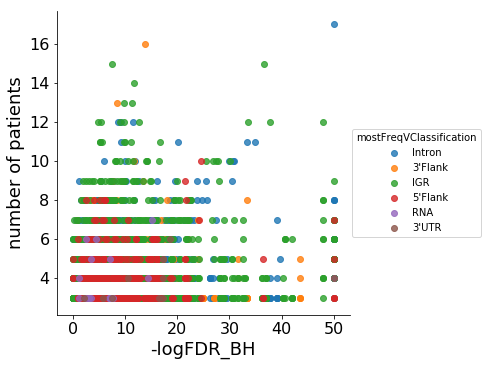

In [75]:
sns.lmplot('-log10fdr', 'num_patient', data=df, hue='mostFreqVClassification', fit_reg=False)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('-logFDR_BH', fontsize=18)
plt.ylabel('number of patients', fontsize=18)

plt.savefig(f'{wkdir}focal_hotspots_distribution.png',bbox_inches='tight' )

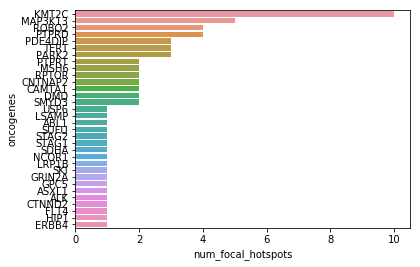

In [83]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/focal_hotspots_counts.txt'
df = pd.read_csv(f, sep='\t')
df = df.sort_values('num_focal_hotspots', ascending=False)
# ax = sns.barplot(x="num_focal_hotspots", y="oncogenes",  data=df)

# df

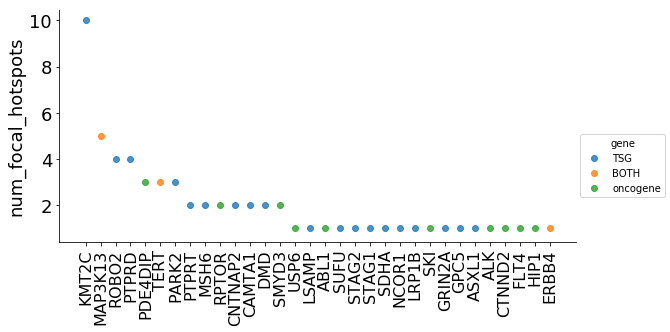

In [107]:
# fig, ax = plt.subplots(figsize=(10,20))
sns.lmplot('oncogenes', "num_focal_hotspots", data=df, hue='gene', fit_reg=False, size=4, aspect=2)
_ = plt.xticks(rotation=90, fontsize=16)
_ = plt.yticks(fontsize=18)
_= plt.xlabel('', fontsize=18)
_= plt.ylabel('num_focal_hotspots', fontsize=18)
plt.savefig(f'{wkdir}oncogen_tsg_num_hotspots.png',bbox_inches='tight' )